## Project Setup

In [ ]:
# install needed libraries
!pip install pyarrow
!pip install fastparquet
!pip install geopandas
!pip install pytest
!pip install keplergl
!pip install bs4

In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import sqlite3
import numpy as np
import matplotlib.animation as animation
import keplergl
from keplergl import KeplerGl
import statistics
import unittest

In [32]:
# add constant
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
taxi_data = pd.read_csv(r"C:\Users\Silvia\Documents\GitHub\Projects-portfolio\Uber_and_Yellow_Taxi\taxi_sample.csv",index_col='Unnamed: 0')
uber_data = pd.read_csv(r"C:\Users\Silvia\Documents\GitHub\Projects-portfolio\Uber_and_Yellow_Taxi\uber_data.csv",index_col='Unnamed: 0')
engine = db.create_engine(DATABASE_URL)

## Visualization 1

_**TODO:** Plot the number of taxi trips per hour of the day._

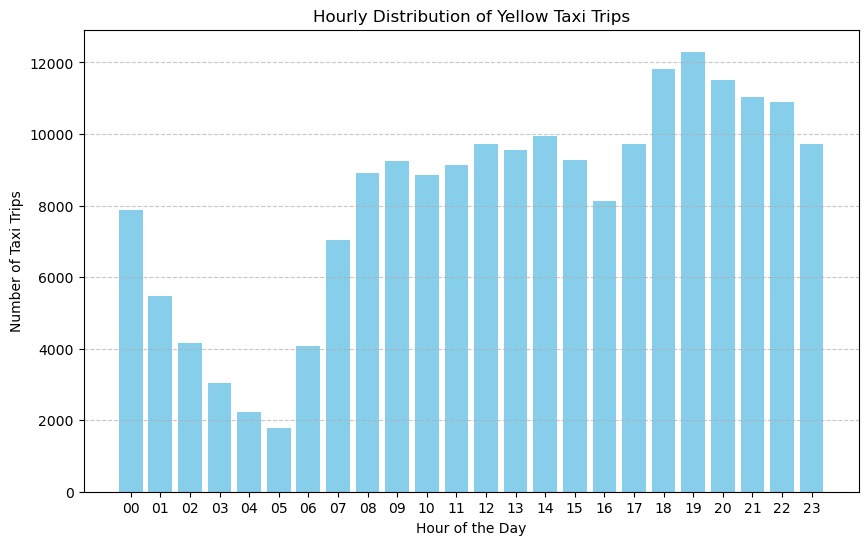

In [20]:
QUERY_4_1 = """
SELECT strftime ('%H',pickup_datetime) AS HOUR,
COUNT(strftime ('%H',pickup_datetime)) AS NUMBERS
FROM taxi_trips
GROUP BY HOUR
"""

def get_data_for_visual_1():
    df = pd.read_sql(QUERY_4_1, con = engine)
    return df

def plot_visual_1(dataframe):
    plt.figure(figsize=(10, 6))
    plt.bar(dataframe['HOUR'], dataframe['NUMBERS'], color='skyblue')
    plt.title('Hourly Distribution of Yellow Taxi Trips')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Taxi Trips')
    plt.xticks(range(24))  # Show all hours on x-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

df = get_data_for_visual_1()
plot_visual_1(df)

## Visualization 2

_**TODO:** Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization._

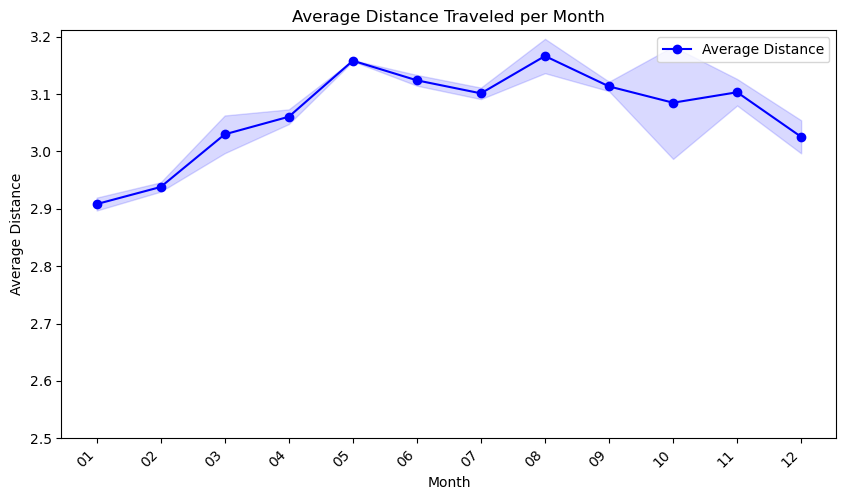

In [24]:
QUERY_4_2 = """
SELECT month,
       total_trips,
       AVG(avr_distance) as average_distance,
       (count(distance)*sum(distance*distance) - (sum(distance)*sum(distance))) / ((count(distance)-1)*(count(distance))) as variance
FROM 
    (SELECT 
        trip_distance AS distance,
        strftime ('%m',pickup_datetime) AS month,
        count(*) AS total_trips,
        AVG(trip_distance) AS avr_distance
    FROM 
        taxi_trips
    GROUP BY 
        strftime ('%m',pickup_datetime)
    UNION 
    SELECT 
        trip_distance AS distance,
        strftime ('%m',pickup_datetime) AS month,
        count(*) AS total_trips,
        AVG(trip_distance) AS avr_distance
    FROM 
        uber_trips
    GROUP BY 
        strftime ('%m',pickup_datetime)
    ) trips
GROUP BY
    trips.month
"""

def get_data_for_visual_2():
    df = pd.read_sql(QUERY_4_2, con=engine)
    return df

# Get data
df = get_data_for_visual_2()

# Calculate confidence intervals
ci_lower = df['average_distance'] - 1.64 * np.sqrt(df['variance']) / np.sqrt(df['total_trips'])
ci_upper = df['average_distance'] + 1.64 * np.sqrt(df['variance']) / np.sqrt(df['total_trips'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = df['month']
ax.plot(x, df['average_distance'], marker='o', color='b', label='Average Distance')
ax.fill_between(x, ci_lower, ci_upper, color='b', alpha=0.15)
ax.set_ylim(ymin=2.5)
ax.set_title('Average Distance Traveled per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Distance')
ax.legend()
fig.autofmt_xdate(rotation=45)
plt.show()

## Visualization 3

_**TODO:** Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport._

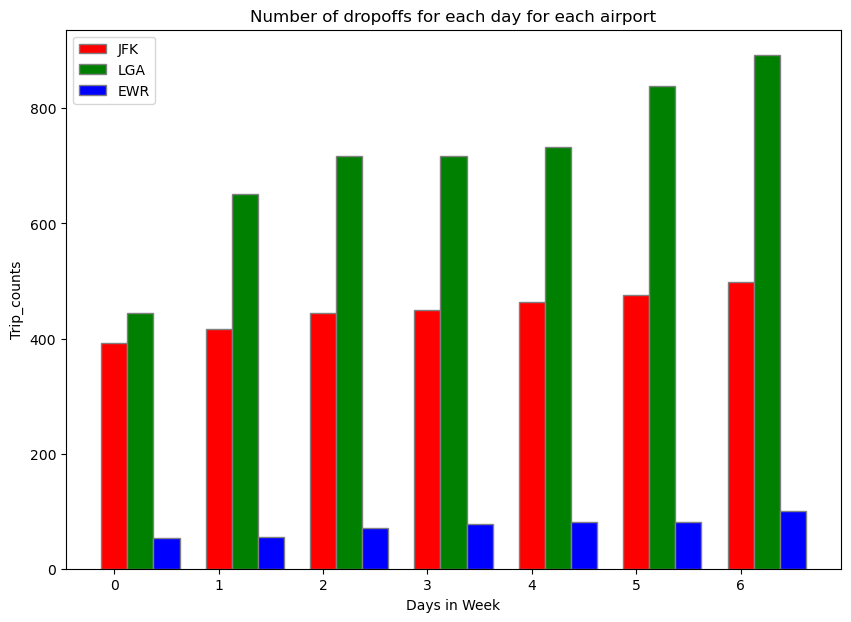

In [30]:
JFK_BOX = [-73.825248, 40.620479, -73.746971, 40.666458]
LGA_BOX = [-73.890716,40.767245,-73.854667,40.781415]
EWR_BOX = [-74.192324,40.670659,-74.153185, 40.708601]

def plot_visual_3():
    query_JFK = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.825248 AND -73.746971 AND dropoff_latitude BETWEEN 40.620479 AND 40.666458
    GROUP BY day
    ORDER BY Trip_counts
    """
    query_LGA = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.890716 AND -73.854667 AND dropoff_latitude BETWEEN 40.767245 AND 40.781415
    GROUP BY day
    ORDER BY Trip_counts
    """

    query_EWR = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -74.192324 AND -74.153185 AND dropoff_latitude BETWEEN 40.670659 AND 40.708601
    GROUP BY day
    ORDER BY Trip_counts
    """

    df_JFK = pd.read_sql(query_JFK, con = engine)
    df_LGA = pd.read_sql(query_LGA, con = engine)
    df_EWR = pd.read_sql(query_EWR, con = engine)
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(10, 7))
    br1 = np.arange(len(df_JFK['day']))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    plt.bar(br1, df_JFK['Trip_counts'], color ='r', width = barWidth,
            edgecolor ='grey', label ='JFK')
    plt.bar(br2, df_LGA['Trip_counts'], color ='g', width = barWidth,
            edgecolor ='grey', label ='LGA')
    plt.bar(br3, df_EWR['Trip_counts'], color ='b', width = barWidth,
            edgecolor ='grey', label ='EWR')

    plt.title('Number of dropoffs for each day for each airport')
    plt.xlabel('Days in Week')
    plt.ylabel('Trip_counts')

    plt.legend()
    plt.show()

plot_visual_3()

## Visualization 4

_**TODO:** Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations._

In [33]:
get_map = KeplerGl(height = 500)
get_map.add_data(uber_data, name = "heatmap")
get_map.add_data(taxi_data, name = "heatmap")
get_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


## Visualization 5

_**TODO:** Plot the number of taxi trips per hour of the day._

## Visualization 6

_**TODO:** Plot the number of taxi trips per hour of the day._